# Financial Market Data Generation
In this project we have implemented some methods for synthetic correlation matrix, and synthetic correlated time series generation. For references you can see the comments of each function. The idea of this project is based on mlfinlab data generation, but the codes were all implemented independently. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from correlated_random_walks import generate_correlated_random_walks
from plotting import plot_time_series, plot_correlation_matrices
from corr_gan import sample_from_corrgan
from hcbm import generate_hcbm_correlation_matrix, time_series_from_correlation_matrix
from bootstrapping import row_bootstrap, pair_bootstrap, block_bootstrap
from data_verification import plot_optimal_hierarchical_cluster, plot_stylized_facts, time_series_dependencies
from vine_extended_onion import sample_from_vine, sample_from_extended_onion


# Correlated random walks
One of the methods for synthetic time-series generation is correlated random walks. In this methods n time-series of returns are generated. These n time-series can be clustered in k correlated groups. And each of the correlated-clusters can be partitioned in d distribution-clusters. 

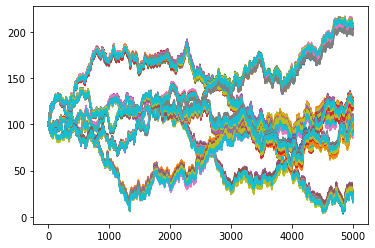

In [3]:
x = generate_correlated_random_walks(n_series=100,
                                     t_points=5000,
                                     k_corr_clusters=5,
                                     d_dist_clusters=2,
                                     beta=0.95,
                                     dists=['normal', 'normal', 't-student'],
                                     rho_main=0)

plot_time_series(x, 100)


# CorrGAN
A method to generate random correlation matrices using a pre-trained generative adversarial network, developed by Gautier Marti. Running the code below might take time. 

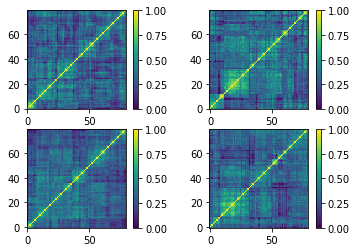

In [1]:
# You should first download the pretrained model

corrgan_matrices = sample_from_corrgan(model_path='corrgan-models/saved_model/generator_{}d',
                                       n=4,
                                       dim=80)
plot_correlation_matrices(corrgan_matrices)


# HCBM(Hierarchical Correlation Block Model)
First method will generate correlation matrices with hcbm model. The second method will generate time series based on the correlation matrix that was obtained from the previous step. 


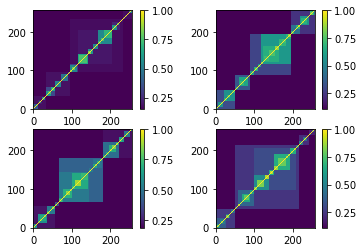

In [3]:
corr_mx = generate_hcbm_correlation_matrix(n=4, dim=256, block=4, depth=4)
plot_correlation_matrices(corr_mx)


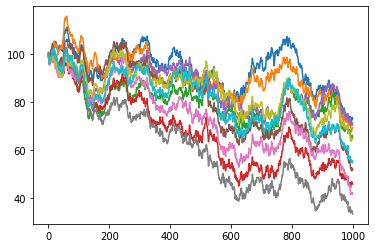

In [4]:
corr_mx = generate_hcbm_correlation_matrix(n=1,
                                           dim=10,
                                           block=2,
                                           depth=2,
                                           lower_bound=0.6)

ts = time_series_from_correlation_matrix(correlation_matrix=corr_mx[0, :, :],
                                         t_points=1000,
                                         distribution_type='normal')

plot_time_series(ts, 100)

# Bootstraping
## 1. Row bootstraping


In [5]:
mx = np.array([_ for _ in range(100)]).reshape(10, 10)
print(row_bootstrap(matrix=mx, n_samples=2, size=(3, 7)))

[[[32 33 34 35 36 37 38]
  [91 92 93 94 95 96 97]
  [41 42 43 44 45 46 47]]

 [[93 94 95 96 97 98 99]
  [32 33 34 35 36 37 38]
  [62 63 64 65 66 67 68]]]


## 2. Pair bootstraping
In this implementation we see four bootstrapped correlation matrices of a time-series that was generated with hcbm method in the previous sections. 

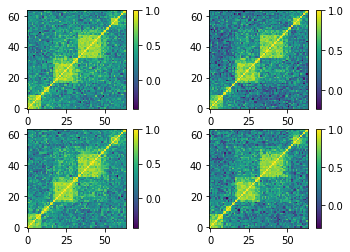

In [8]:
corr_mx = generate_hcbm_correlation_matrix(n=1, dim=64, block=3, depth=3)

ts = time_series_from_correlation_matrix(correlation_matrix=corr_mx[0, :, :],
                                         t_points=300,
                                         distribution_type='normal')

bootstrapped_corr_matrices = pair_bootstrap(matrix=ts.T,
                                            n_samples=4,
                                            size=40)

plot_correlation_matrices(bootstrapped_corr_matrices)


## 3. Block bootstrapping


In [9]:
mx = np.array([_ for _ in range(100)]).reshape(10, 10)
block_bootstraped_matrices = block_bootstrap(matrix=mx,
                                             n_samples=2,
                                             size=(6, 6),
                                             block_size=(2, 3))
print(block_bootstraped_matrices)


[[[40 41 42 23 24 25]
  [50 51 52 33 34 35]
  [83 84 85 87 88 89]
  [93 94 95 97 98 99]
  [ 0  1  2 67 68 69]
  [10 11 12 77 78 79]]

 [[26 27 28 43 44 45]
  [36 37 38 53 54 55]
  [40 41 42 83 84 85]
  [50 51 52 93 94 95]
  [87 88 89 60 61 62]
  [97 98 99 70 71 72]]]


# Data Verification
## Optimal Hierarchical Structure
In the code below we have obtained the optimal hierarchical structure of a correlation matrix that was the result of HCBM after permutation. 

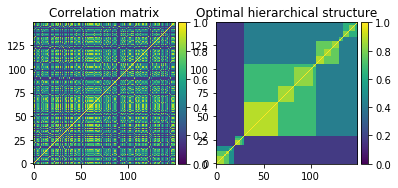

In [13]:
fig, ax = plt.subplots(1, 2)
matrix = generate_hcbm_correlation_matrix(dim=150,
                                          block=4,
                                          depth=3,
                                          permute=True)

plot_correlation_matrices(matrix[0], axis=ax[0])
plot_optimal_hierarchical_cluster(axis=ax[1],
                                  correlation_matrix=matrix[0],
                                  method='average')
plt.show()

## Stylized Facts
The code below will plot stylized facts for 100 correaltion matrices generated with the corr-gan versus 100 correlation matrices generated with HCBM. The functionality of all the functions: [plot_pairwise_correlation_dist, plot_eigenvalues_distribution, plot_first_eigenvetors_entries_distribution, plot_optimal_hierarchical_cluster, plot_hierarchical_structure, plot_mst_degree_count] could be seen in this code. Each of the mentioned functions can be used separately or together for plotting and comparing synthetic data vs real data. 

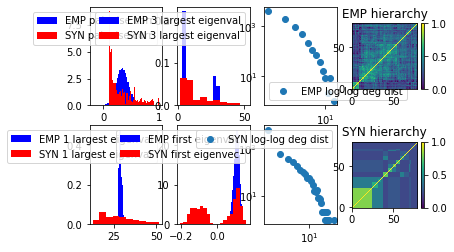

In [4]:
# 'corr_gan_generated.txt' is a file of 100 correlated matrices generated with corr-gan method. This file won't be uploaded on github

corr_gan_matrices = np.loadtxt('corr_gan_generated.txt').reshape(100, 80, 80)
hcbm_matrices = generate_hcbm_correlation_matrix(n=100,
                                                 dim=80, 
                                                 block=4,
                                                 depth=3,
                                                 permute=True)

plot_stylized_facts(empirical_matrix=corr_gan_matrices, synthetic_matrix=hcbm_matrices)

## Time Series Dependencie with GPR and GNPR
You can see the output in different situations below. As you can confit the gpr method can find correlation clusters while the gnpr method can find distribution clusters alongside correlation clusters. 

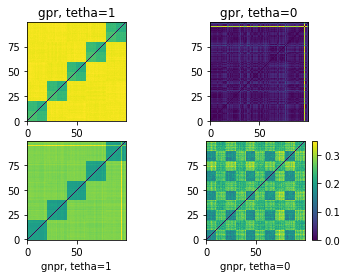

In [8]:
x = generate_correlated_random_walks(n_series=100,
                                     t_points=5000,
                                     k_corr_clusters=5,
                                     d_dist_clusters=2,
                                     beta=0.5,
                                     dists=['normal', 'normal', 't-student', 'normal', 't-student'],
                                     rho_main=0)


distance1 = time_series_dependencies(time_series=x, dependence_method='gpr', tetha=1, h=0.1)
distance2 = time_series_dependencies(time_series=x, dependence_method='gpr', tetha=0, h=0.1)
distance3 = time_series_dependencies(time_series=x, dependence_method='gnpr', tetha=1, h=0.1)
distance4 = time_series_dependencies(time_series=x, dependence_method='gnpr', tetha=0, h=0.1)

plt.subplot(2, 2, 1)
plt.title('gpr, tetha=1')
img = plt.imshow(distance1, origin='lower')
plt.subplot(2, 2, 2)
plt.title('gpr, tetha=0')
img = plt.imshow(distance2, origin='lower')
plt.subplot(2, 2, 3)
plt.xlabel('gnpr, tetha=1')
img = plt.imshow(distance3, origin='lower')
plt.subplot(2, 2, 4)
plt.xlabel('gnpr, tetha=0')
img = plt.imshow(distance4, origin='lower')
plt.colorbar(img)
plt.show()

# C-Vine and D-Vine
The codes below will generate random correlation matrices with vine methods. 
Notice that there is no documentation on how to update (alpha, beta) parameters in each step for the case that alpha and beta of the Beta distribution are asymmetric, this case is just implemented in mlfinlab and it doesn't exists in the reference papers. But you can also generate biased matrices with the parameters that we used below. 
## Ubiased case with alpha=beta:

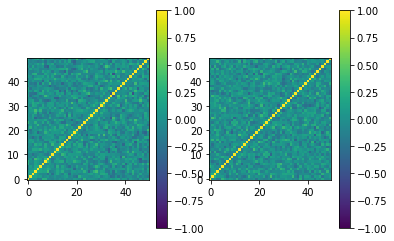

In [2]:
res = sample_from_vine(n=2, dim=50, method='dvine')
plot_correlation_matrices(res, min=-1, max=1)

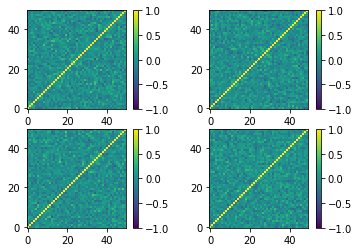

In [3]:
res = sample_from_vine(n=4, dim=50, method='cvine')
plot_correlation_matrices(res, min=-1, max=1)

## Extended Onion Method


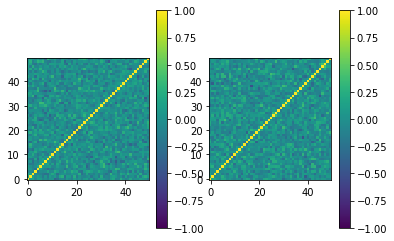

In [4]:
res = sample_from_extended_onion(n=2, dim=50)
plot_correlation_matrices(res, min=-1, max=1)